In [ ]:
# https://www.kaggle.com/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner

# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

In [84]:
from keras.applications.vgg16 import VGG16
from tensorflow import keras

In [85]:
model = VGG16(weights='imagenet')

In [86]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

outputs = VGG16(include_top=True, weights=None, classes=2)(inputs)
model = keras.Model(inputs, outputs)

model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [87]:
import tensorflow as tf
import numpy as np
import pathlib

# step 1
IMAGE_PATHS_DIR = r"C:\Users\na-ch\Desktop\estudio\Master_Big_Data\03_TFM\02_Code\dataset_test\CASIA_IrisV1_unif"
# IMAGE_PATHS_DIR = r"C:\Users\na-ch\Desktop\estudio\Master_Big_Data\03_TFM\04_GitHub_Master\iris_classifier-master\notebooks\old\CASIA_v1"
paths = np.array([x.__str__() for x in pathlib.Path(IMAGE_PATHS_DIR).rglob('*.bmp')])
filenames = tf.constant(paths)

labels_array = np.array([x.split("\\")[-1].split("_")[0] for x in paths])
labels = tf.constant(labels_array)

n_clases = np.max([int(i) for i in labels_array])

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

def _parse_function(filename, label):
    img = tf.io.read_file(filename)
    image = tf.image.decode_bmp(img, channels = 3)
    label = tf.one_hot(int(label), n_clases) 
    return image, label

dataset_map = dataset.map(_parse_function)

dataset_map = dataset_map.shuffle(10)

dataset_len = len(dataset_map)

train_size = int(0.7 * dataset_len)
val_size = int(0.15 * dataset_len)
test_size = int(0.15 * dataset_len)

train_ds = dataset_map.take(train_size)
test_ds = dataset_map.skip(train_size)
validation_ds = test_ds.skip(val_size)
test_ds = test_ds.skip(test_size)

size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)



In [88]:
epochs = 5  # @param {type: "slider", min:10, max:100}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Epoch 1/5
1/1 - 40s - loss: 0.3790 - accuracy: 0.5556 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 40s/epoch - 40s/step
Epoch 2/5
1/1 - 7s - loss: 0.0000e+00 - accuracy: 0.4444 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 7s/epoch - 7s/step
Epoch 3/5
1/1 - 6s - loss: 0.0000e+00 - accuracy: 0.4444 - val_loss: 129355304.0000 - val_accuracy: 0.6667 - 6s/epoch - 6s/step
Epoch 4/5
1/1 - 6s - loss: 177687824.0000 - accuracy: 0.5556 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 6s/epoch - 6s/step
Epoch 5/5
1/1 - 6s - loss: 0.0000e+00 - accuracy: 0.4444 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 6s/epoch - 6s/step


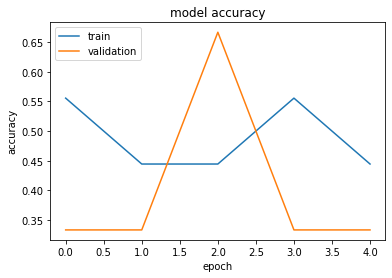

In [89]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [95]:
from tensorflow.keras import layers


def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = img_augmentation(inputs)
    model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [96]:
model = build_model(num_classes=n_clases)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)


Epoch 1/10
1/1 - 3s - loss: 0.5986 - accuracy: 0.3333 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 3s/epoch - 3s/step
Epoch 2/10
1/1 - 2s - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 2s/epoch - 2s/step
Epoch 3/10
1/1 - 2s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 2s/epoch - 2s/step
Epoch 4/10
1/1 - 2s - loss: 0.0069 - accuracy: 0.8889 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 2s/epoch - 2s/step
Epoch 5/10
1/1 - 2s - loss: 0.0079 - accuracy: 0.8889 - val_loss: 3.9736e-08 - val_accuracy: 0.3333 - 2s/epoch - 2s/step
Epoch 6/10
1/1 - 2s - loss: 0.0332 - accuracy: 1.0000 - val_loss: 7.9473e-08 - val_accuracy: 0.3333 - 2s/epoch - 2s/step
Epoch 7/10
1/1 - 2s - loss: 0.0281 - accuracy: 1.0000 - val_loss: 1.5895e-07 - val_accuracy: 0.3333 - 2s/epoch - 2s/step
Epoch 8/10
1/1 - 2s - loss: 0.0301 - accuracy: 0.5556 - val_loss: 3.1789e-07 - val_accuracy: 0.3333 - 2s/epoch - 2s/step
Epoch 9/10
1/1 - 2s - loss: 0.01

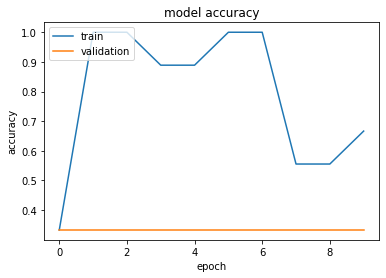

In [97]:
plot_hist(hist)

Epoch 1/5
1/1 - 5s - loss: 0.0236 - accuracy: 0.5556 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - 5s/epoch - 5s/step
Epoch 2/5
1/1 - 4s - loss: 0.0051 - accuracy: 0.8889 - val_loss: 4.5892e-05 - val_accuracy: 0.3333 - 4s/epoch - 4s/step
Epoch 3/5
1/1 - 5s - loss: 0.1811 - accuracy: 0.3333 - val_loss: 3.9736e-08 - val_accuracy: 0.3333 - 5s/epoch - 5s/step
Epoch 4/5
1/1 - 4s - loss: 0.0091 - accuracy: 0.6667 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 4s/epoch - 4s/step
Epoch 5/5
1/1 - 4s - loss: 0.0055 - accuracy: 0.6667 - val_loss: 0.0000e+00 - val_accuracy: 0.3333 - 4s/epoch - 4s/step


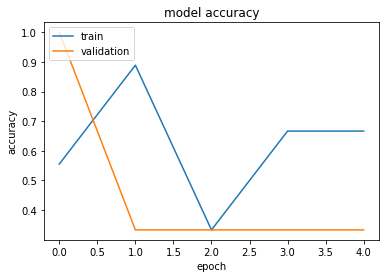

In [98]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 5  # @param {type: "slider", min:8, max:50}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)
plot_hist(hist)

In [107]:
size = (224, 224)

def _parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_bmp(img, channels = 3)
    img = tf.image.resize(img, size)
    img = tf.expand_dims(img, 0)
    return img

try_image_path =  r"C:\Users\na-ch\Desktop\estudio\Master_Big_Data\03_TFM\02_Code\dataset_test\CASIA_IrisV1_unif\001_2_2.bmp"
try_image = _parse_image(try_image_path)

In [108]:
result = model.predict(try_image)
np.argmax(result)

1

In [109]:
result

array([[6.3568118e-12, 1.0000000e+00]], dtype=float32)

In [36]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 100%|██████████| 1/1 [01:36<00:00, 96.85s/ url]
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:  50%|█████     | 1/2 [00:03<00:03,  3.02s/ url]

Dl Completed...: 100%|██████████| 2/2 [00:07<00:00,  3.45s/ url]

Dl Completed...: 100%|██████████| 2/2 [23:34<00:00, 707.12s/ url]


Dataset stanford_dogs downloaded and prepared to C:\Users\Ignacio\tensorflow_datasets\stanford_dogs\0.2.0. Subsequent calls will reuse this data.


In [37]:
IMG_SIZE = 224

size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [38]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [51]:
x = 0
for i, a in ds_test:
    if x < 1:
        print(a.numpy()==1) 
        print("-----")
        x +=1
    else:
        break

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
-----


In [39]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

model = tf.keras.Model(inputs, outputs)
model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 1  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 120)              4203291   
                                                                 
Total params: 4,203,291
Trainable params: 4,161,268
Non-trainable params: 42,023
_________________________________________________________________
187/187 - 2164s - loss: 4.9647 - accuracy: 0.0119 - val_loss: 5.2710 - val_accuracy: 0.0139 - 2164s/epoch - 12s/step
